In [42]:
import copy
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import cross_val_score,cross_validate
from sklearn.metrics import matthews_corrcoef as mcc
from sklearn.metrics import roc_curve,roc_auc_score,precision_recall_curve,classification_report,accuracy_score
#Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import scikitplot as skplt
#classifiers End


import warnings
warnings.filterwarnings("ignore")

# Data Reading

In [7]:
data = pd.read_csv("./data/nndb_flat.csv")

In [9]:
data.notnull()
data = data.drop(columns=['CommonName','MfgName','ScientificName'])

In [10]:
data.head()

,ID,FoodGroup,ShortDescrip,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Dairy and Egg Products,"BUTTER,WITH SALT","Butter, salted",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Dairy and Egg Products,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Dairy and Egg Products,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",876.0,0.28,99.48,0.00,0.00,0.0,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Dairy and Egg Products,"CHEESE,BLUE","Cheese, blue",353.0,21.40,28.74,2.34,0.50,0.0,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Dairy and Egg Products,"CHEESE,BRICK","Cheese, brick",371.0,23.24,29.68,2.79,0.51,0.0,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


# Data Processing

In [11]:
groups = np.array(data['FoodGroup'])
len(set(groups))

25

In [39]:
set(groups)

{'American Indian/Alaska Native Foods',
 'Baby Foods',
 'Baked Products',
 'Beef Products',
 'Beverages',
 'Breakfast Cereals',
 'Cereal Grains and Pasta',
 'Dairy and Egg Products',
 'Fast Foods',
 'Fats and Oils',
 'Finfish and Shellfish Products',
 'Fruits and Fruit Juices',
 'Lamb, Veal, and Game Products',
 'Legumes and Legume Products',
 'Meals, Entrees, and Side Dishes',
 'Nut and Seed Products',
 'Pork Products',
 'Poultry Products',
 'Restaurant Foods',
 'Sausages and Luncheon Meats',
 'Snacks',
 'Soups, Sauces, and Gravies',
 'Spices and Herbs',
 'Sweets',
 'Vegetables and Vegetable Products'}

In [14]:
nonveg = [
 'American Indian/Alaska Native Foods',
 'Beef Products',
 'Dairy and Egg Products',
 'Finfish and Shellfish Products',
 'Lamb, Veal, and Game Products',
 'Pork Products',
 'Poultry Products',
 'Sausages and Luncheon Meats',]
remove = ['Restaurant Foods','Meals, Entrees, and Side Dishes', 'Fast Foods', 'Baked Products',]

In [15]:
len(remove)

4

In [16]:
newlabels = []
index = []
j = 0
for i in groups:
    if(i in nonveg):
        newlabels.append('Non-Veg')
    elif(i in remove):
        newlabels.append('Remove')
        index.append(j)
    else:
        newlabels.append('Veg')
    j+=1

In [18]:
len(index)

1389

In [19]:
from collections import Counter

In [20]:
Counter(newlabels)

Counter({'Non-Veg': 3057, 'Veg': 4172, 'Remove': 1389})

In [21]:
data['FoodGroup'] = newlabels

In [22]:
data.head()

,ID,FoodGroup,ShortDescrip,Descrip,Energy_kcal,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,1001,Non-Veg,"BUTTER,WITH SALT","Butter, salted",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,1002,Non-Veg,"BUTTER,WHIPPED,WITH SALT","Butter, whipped, with salt",717.0,0.85,81.11,0.06,0.06,0.0,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,1003,Non-Veg,"BUTTER OIL,ANHYDROUS","Butter oil, anhydrous",876.0,0.28,99.48,0.00,0.00,0.0,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,1004,Non-Veg,"CHEESE,BLUE","Cheese, blue",353.0,21.40,28.74,2.34,0.50,0.0,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,1005,Non-Veg,"CHEESE,BRICK","Cheese, brick",371.0,23.24,29.68,2.79,0.51,0.0,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


In [23]:
datacopy = copy.deepcopy(data)

In [52]:
vegdata = datacopy.loc[datacopy['FoodGroup'] == 'Veg']
nonveg = datacopy.loc[datacopy['FoodGroup'] == 'Non-Veg']

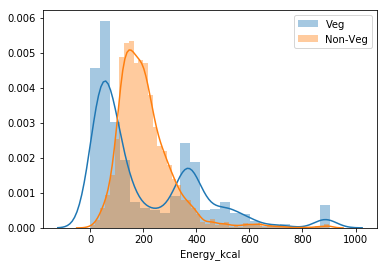

In [53]:
sns.distplot(vegdata['Energy_kcal'])
sns.distplot(nonveg['Energy_kcal'])
plt.legend(['Veg','Non-Veg'])

In [24]:
data = data.loc[data['FoodGroup'] != 'Remove']

In [25]:
len(data)

7229

In [26]:
data = data.drop(columns=['ShortDescrip','Descrip','ID'])

In [27]:
energy = data['Energy_kcal']
label = data['FoodGroup']

In [28]:
data = data.drop(columns=['Energy_kcal','FoodGroup'])

In [29]:
data.head()

,Protein_g,Fat_g,Carb_g,Sugar_g,Fiber_g,VitA_mcg,VitB6_mg,VitB12_mcg,VitC_mg,VitE_mg,...,Folate_USRDA,Niacin_USRDA,Riboflavin_USRDA,Thiamin_USRDA,Calcium_USRDA,Copper_USRDA,Magnesium_USRDA,Phosphorus_USRDA,Selenium_USRDA,Zinc_USRDA
0,0.85,81.11,0.06,0.06,0.0,684.0,0.003,0.17,0.0,2.32,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000000,0.004762,0.034286,0.018182,0.008182
1,0.85,81.11,0.06,0.06,0.0,684.0,0.003,0.13,0.0,2.32,...,0.0075,0.002625,0.026154,0.004167,0.020000,0.000018,0.004762,0.032857,0.018182,0.004545
2,0.28,99.48,0.00,0.00,0.0,840.0,0.001,0.01,0.0,2.80,...,0.0000,0.000188,0.003846,0.000833,0.003333,0.000001,0.000000,0.004286,0.000000,0.000909
3,21.40,28.74,2.34,0.50,0.0,198.0,0.166,1.22,0.0,0.25,...,0.0900,0.063500,0.293846,0.024167,0.440000,0.000044,0.054762,0.552857,0.263636,0.241818
4,23.24,29.68,2.79,0.51,0.0,292.0,0.065,1.26,0.0,0.26,...,0.0500,0.007375,0.270000,0.011667,0.561667,0.000027,0.057143,0.644286,0.263636,0.236364


# Methods for Computations

In [30]:
def r_o_c(true_labels,scores):
#     true_labels = np.array(true_labels)
    true_labels= true_labels.replace('Veg',1)
    true_labels= true_labels.replace('Non-Veg',0)
    plt.figure()
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    plt.plot(fpr, tpr)

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')

    plt.title('ROC Curve')
    plt.show()



def reports(classifier,train_data,train_labels,test_data,test_labels,name='',tree_flag = 0):
    print ("==================================================================================")
    print (name)
    print ("==================================================================================")
#     kf = KFold(n_splits=5)
#     kf.get_n_splits(train_data)
#     print(kf)
    scores = []
    best_train = []
    best_train_labels = []
    maxscore = 0
    scores = cross_validate(classifier, train_data, train_labels, cv=5,scoring=('f1_macro', 'accuracy','roc_auc'),return_train_score=False)
    scores = pd.DataFrame(data=scores)
    scores = scores.drop(columns=['fit_time','score_time'])
    print (scores)
    
    train_x = train_data
    train_y = train_labels

    test_x = test_data
    test_y = test_labels
    
    classifier.fit(train_x,train_y)
    predicted = classifier.predict(test_x)
    print ("Test Data Results:")
    print ("Test Accuracy: ",accuracy_score(predicted,test_y))
    X = classification_report(test_y,predicted,output_dict=True)
    skplt.metrics.plot_confusion_matrix(test_y, predicted)
    plt.figure()
    #print (X.keys())
    print (classification_report(test_y,predicted))
    print ("Sensitivity: ", X['Non-Veg']['recall'])
    print ("Specificity: ", X['Veg']['recall'])
    print ("MCC: ",mcc(test_y,predicted))
    print ("__________________________________________________________________________________")
    prob_scores = classifier.predict_proba(test_x)
    print ("ROC AUC",roc_auc_score(y_true=test_labels,y_score=prob_scores[:,1]))
    r_o_c(test_labels,prob_scores[:,1])

    if(tree_flag):
        return classifier

# Train Test Split

In [31]:
data,label = shuffle(data,label) 
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.30)

# Gaussian Naive Bayes

Gaussian Naive Bayes
   test_f1_macro  test_accuracy  test_roc_auc
0       0.687000       0.691700      0.944064
1       0.678975       0.683794      0.934348
2       0.687927       0.692688      0.954223
3       0.736847       0.738142      0.951025
4       0.724796       0.727273      0.961859
Test Data Results:
Test Accuracy:  0.6906408483171969
              precision    recall  f1-score   support

     Non-Veg       0.58      0.97      0.72       902
         Veg       0.96      0.49      0.65      1267

    accuracy                           0.69      2169
   macro avg       0.77      0.73      0.69      2169
weighted avg       0.80      0.69      0.68      2169

Sensitivity:  0.9722838137472284
Specificity:  0.49013417521704816
MCC:  0.4983794037717869
__________________________________________________________________________________
ROC AUC 0.9594175532054525


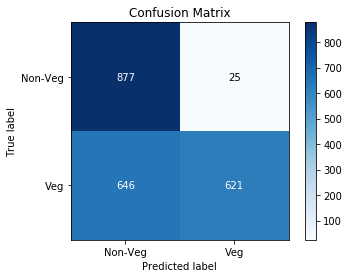

<Figure size 432x288 with 0 Axes>

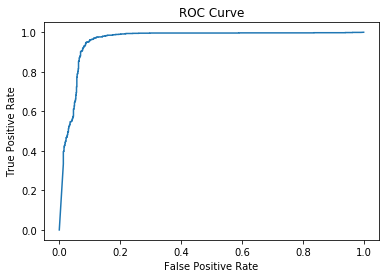

In [32]:
clf_gnb = GaussianNB()
reports(name = 'Gaussian Naive Bayes',classifier=clf_gnb,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

# Logistic Regression

Logistic Regression
   test_f1_macro  test_accuracy  test_roc_auc
0       0.955349       0.956522      0.969782
1       0.937165       0.938735      0.973170
2       0.966587       0.967391      0.974518
3       0.942393       0.943676      0.978415
4       0.950226       0.951581      0.972070
Test Data Results:
Test Accuracy:  0.9538958045182112
              precision    recall  f1-score   support

     Non-Veg       0.95      0.94      0.94       902
         Veg       0.96      0.96      0.96      1267

    accuracy                           0.95      2169
   macro avg       0.95      0.95      0.95      2169
weighted avg       0.95      0.95      0.95      2169

Sensitivity:  0.9434589800443459
Specificity:  0.9613259668508287
MCC:  0.9050756418794569
__________________________________________________________________________________
ROC AUC 0.9752107480176474


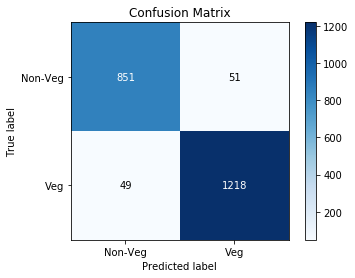

<Figure size 432x288 with 0 Axes>

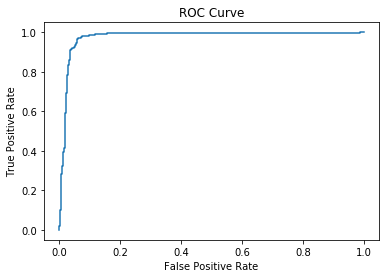

In [33]:
clf_logistic = LogisticRegression(random_state=0# Gaussian Naive Bayes, solver='lbfgs',multi_class='multinomial')
reports(name = 'Logistic Regression',classifier=clf_logistic,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

# Decision Tree

Decision Tree
   test_f1_macro  test_accuracy  test_roc_auc
0       0.951322       0.952569      0.953614
1       0.964690       0.965415      0.965387
2       0.958730       0.959486      0.960495
3       0.951533       0.952569      0.951620
4       0.949422       0.950593      0.949583
Test Data Results:
Test Accuracy:  0.9626556016597511
              precision    recall  f1-score   support

     Non-Veg       0.95      0.96      0.96       902
         Veg       0.97      0.96      0.97      1267

    accuracy                           0.96      2169
   macro avg       0.96      0.96      0.96      2169
weighted avg       0.96      0.96      0.96      2169

Sensitivity:  0.9611973392461197
Specificity:  0.9636937647987371
MCC:  0.9233194198134717
__________________________________________________________________________________
ROC AUC 0.9623996135921752


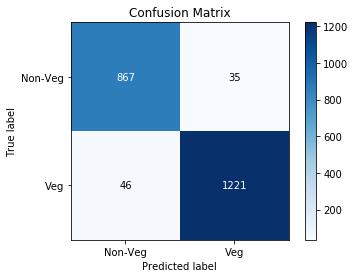

<Figure size 432x288 with 0 Axes>

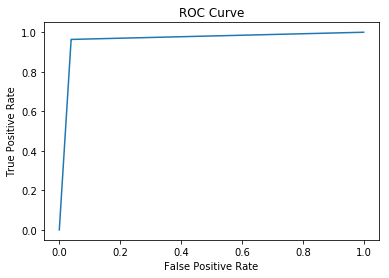

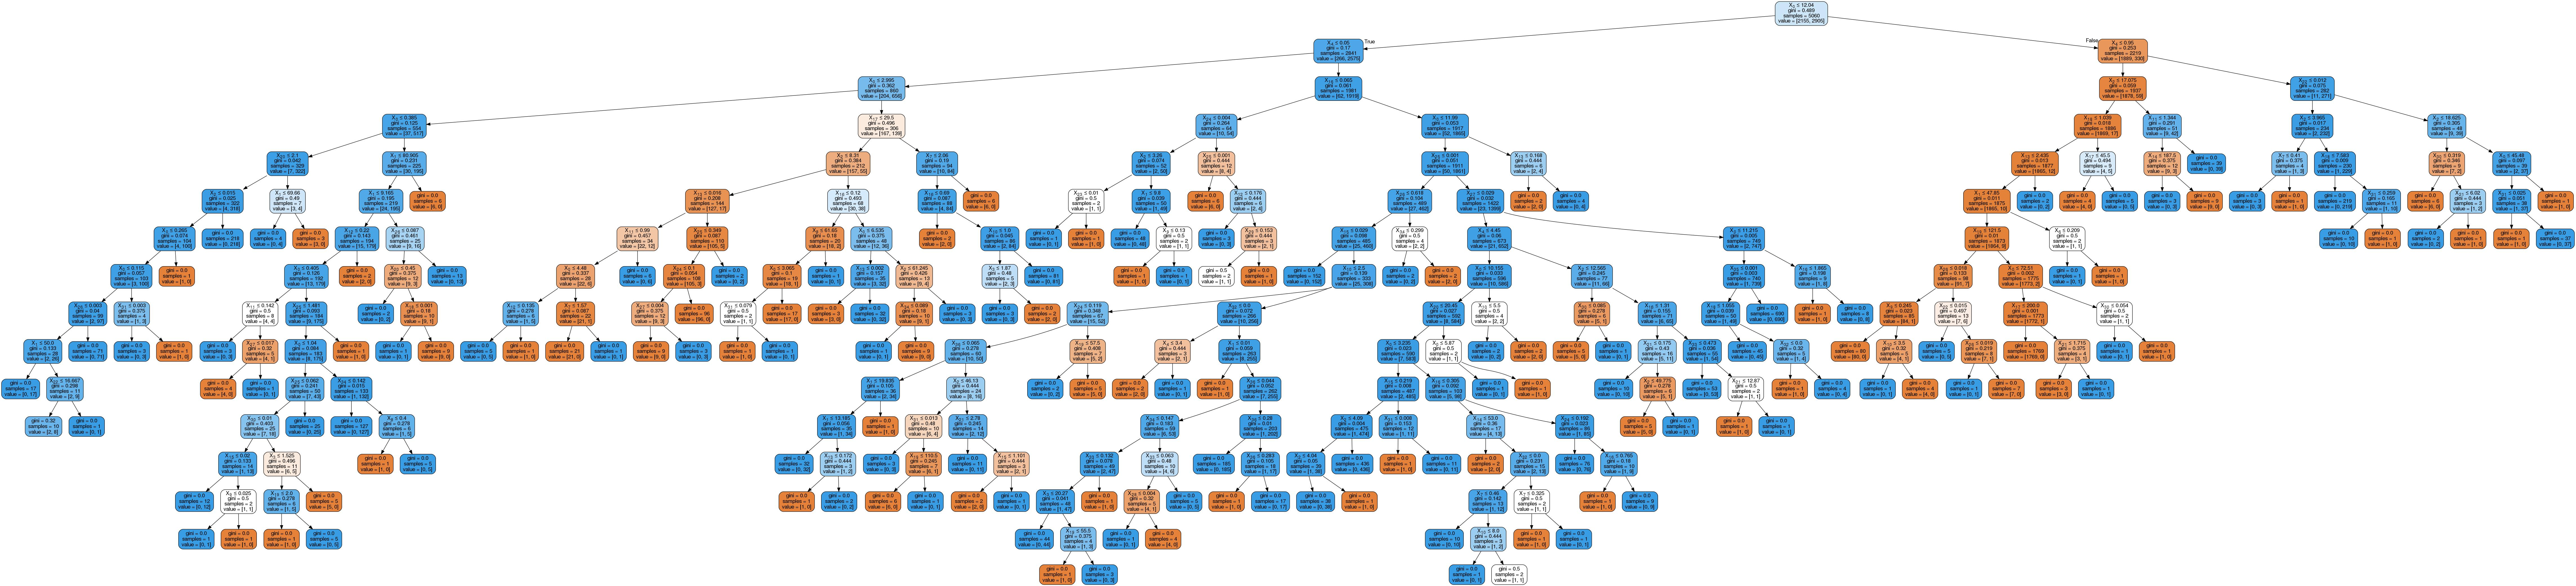

In [34]:
clf_decision_tree = DecisionTreeClassifier(random_state=0)

image = reports(name = 'Decision Tree',classifier=clf_decision_tree,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test,tree_flag=1)
dot_data = StringIO()
export_graphviz(image, out_file=dot_data,  
       filled=True, rounded=True,
       special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
#         img= graph.create_jpeg()
Image(graph.create_jpeg())
#         plt.imshow(img)

# Multinomial Naive Bayes

Multinomial Naive Bayes
   test_f1_macro  test_accuracy  test_roc_auc
0       0.881953       0.883399      0.926860
1       0.893444       0.895257      0.927643
2       0.903186       0.904150      0.953225
3       0.888725       0.890316      0.927002
4       0.907881       0.909091      0.953578
Test Data Results:
Test Accuracy:  0.9068695251267865
              precision    recall  f1-score   support

     Non-Veg       0.86      0.93      0.89       902
         Veg       0.95      0.89      0.92      1267

    accuracy                           0.91      2169
   macro avg       0.90      0.91      0.91      2169
weighted avg       0.91      0.91      0.91      2169

Sensitivity:  0.9312638580931264
Specificity:  0.8895027624309392
MCC:  0.8128441734476113
__________________________________________________________________________________
ROC AUC 0.9465937310230532


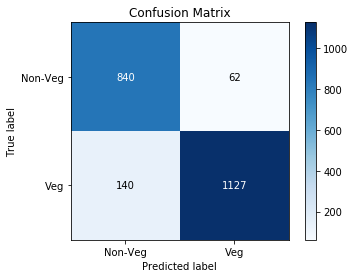

<Figure size 432x288 with 0 Axes>

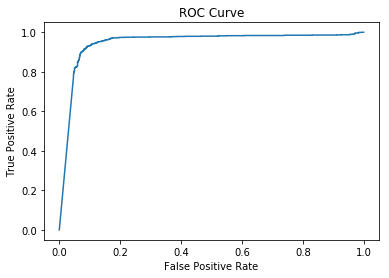

In [35]:
clf_mnb = MultinomialNB()
reports(name = 'Multinomial Naive Bayes',classifier=clf_mnb,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

# Random Forest

Random Forest
   test_f1_macro  test_accuracy  test_roc_auc
0       0.930904       0.933794      0.974614
1       0.926840       0.929842      0.977649
2       0.944648       0.946640      0.983625
3       0.940407       0.942688      0.977066
4       0.936348       0.938735      0.972477
Test Data Results:
Test Accuracy:  0.9446749654218534
              precision    recall  f1-score   support

     Non-Veg       0.97      0.89      0.93       902
         Veg       0.93      0.98      0.95      1267

    accuracy                           0.94      2169
   macro avg       0.95      0.94      0.94      2169
weighted avg       0.95      0.94      0.94      2169

Sensitivity:  0.8913525498891353
Specificity:  0.9826361483820047
MCC:  0.887093430317214
__________________________________________________________________________________
ROC AUC 0.9826396484528811


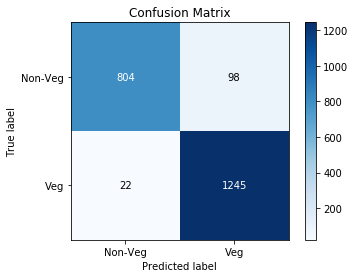

<Figure size 432x288 with 0 Axes>

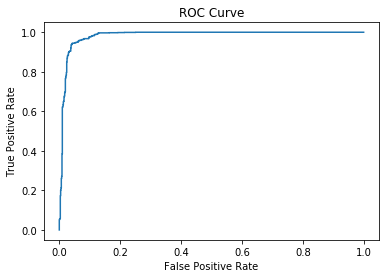

In [36]:
clf_randomforest = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=0)
reports(name = 'Random Forest',classifier=clf_randomforest,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

# XG Boost

XG Boost
   test_f1_macro  test_accuracy  test_roc_auc
0       0.970600       0.971344      0.994461
1       0.969556       0.970356      0.995126
2       0.979756       0.980237      0.998211
3       0.980725       0.981225      0.997169
4       0.975661       0.976285      0.997161
Test Data Results:
Test Accuracy:  0.9801751959428308
              precision    recall  f1-score   support

     Non-Veg       0.98      0.97      0.98       902
         Veg       0.98      0.99      0.98      1267

    accuracy                           0.98      2169
   macro avg       0.98      0.98      0.98      2169
weighted avg       0.98      0.98      0.98      2169

Sensitivity:  0.9700665188470067
Specificity:  0.9873717442778216
MCC:  0.9591754995596457
__________________________________________________________________________________
ROC AUC 0.9963153003848328


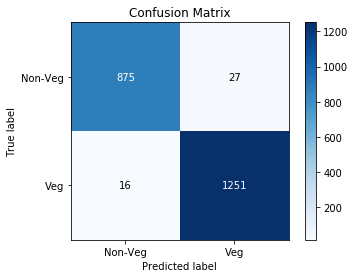

<Figure size 432x288 with 0 Axes>

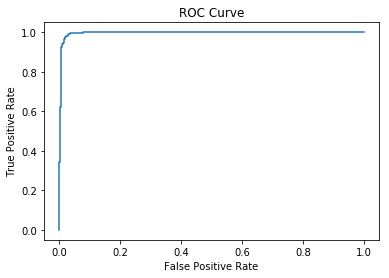

In [37]:
clf_xgb = XGBClassifier(learning_rate=0.1, n_estimators=150, max_depth=10,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=27)
reports(name = 'XG Boost',classifier=clf_xgb,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test)

# Decision Tree 

Decision Tree Mod
   test_f1_macro  test_accuracy  test_roc_auc
0       0.959299       0.960474      0.961825
1       0.959435       0.960474      0.970297
2       0.968531       0.969368      0.974947
3       0.957264       0.958498      0.964628
4       0.958117       0.959486      0.962450
Test Data Results:
Test Accuracy:  0.9691101890272015
              precision    recall  f1-score   support

     Non-Veg       0.98      0.95      0.96       902
         Veg       0.96      0.98      0.97      1267

    accuracy                           0.97      2169
   macro avg       0.97      0.97      0.97      2169
weighted avg       0.97      0.97      0.97      2169

Sensitivity:  0.9490022172949002
Specificity:  0.9834254143646409
MCC:  0.9364307312089986
__________________________________________________________________________________
ROC AUC 0.9731723942409832


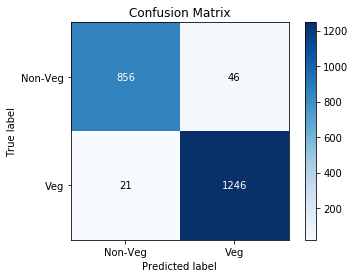

<Figure size 432x288 with 0 Axes>

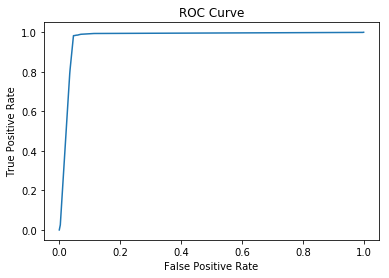

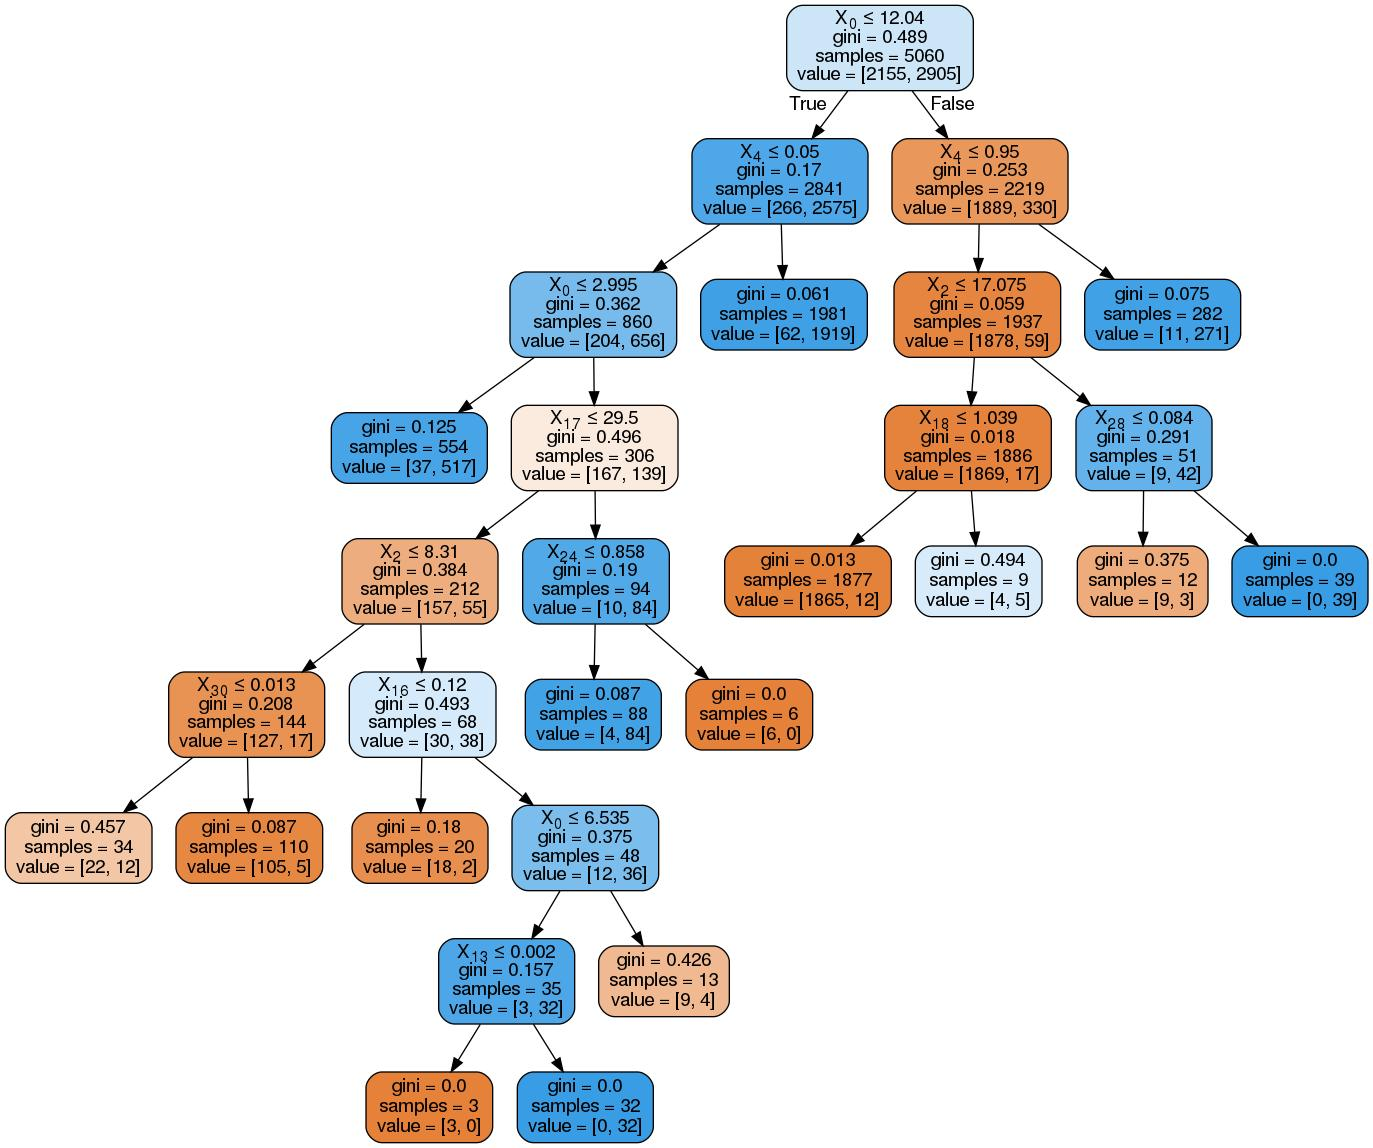

In [40]:
clf_decision_tree_mod = DecisionTreeClassifier(random_state=0,max_depth=10,max_leaf_nodes=15)

image = reports(name = 'Decision Tree Mod',classifier=clf_decision_tree_mod,train_data=X_train,test_data=X_test,train_labels=y_train,test_labels=y_test,tree_flag=1)
dot_data = StringIO()
export_graphviz(image, out_file=dot_data,  
       filled=True, rounded=True,
       special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_jpeg())